# Notebook for calculating Bispectrum
This notebook illustrates how to calculate the vanilla halo model bispectrum with this code

## Preparations

In [19]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb
import pyccl as ccl

# Project imports
#import pyhalomodel as halo
#import pyhalomodel as halo

import sys
sys.path.insert(1, '../pyhalomodel/')
from hmcode import BiHMCode_bispectrum


In [27]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 2e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # [eV]
sigma_8_set = True # If True uses the following value
sigma_8  = 0.8

# Wavenumber range [h/Mpc]
kmin, kmax = 1e-3, 100.
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.
a=1/(1+z)

# Halo mass range [Msun/h] over which to integrate
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

## Calculate linear powerspectrum (with CAMB)

In [30]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()
wb = Omega_b*h**2
wc = Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if sigma_8_set:
    camb_results = camb.get_results(pars)
    sigma_8_init = (camb_results.get_sigma8()[[z].index(0.)]).item()
    print('Initial sigma_8:', sigma_8_init)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Now get the linear power spectrum
Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear=False, 
                                            hubble_units=True, 
                                            k_hunit=True, 
                                            kmax=kmax_CAMB,
                                            var1=camb.model.Transfer_tot,
                                            var2=camb.model.Transfer_tot, 
                                            zmax=zmax_CAMB,
                                           )
Omega_m  = pars.omegam # Also extract the matter density
Pks_lin = Pk_lin.P(z, ks) # Single out the linear P(k) interpolator and evaluate linear power
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[[z].index(0.)]).item()
if sigma_8_set: print('Final sigma_8:', sigma_8)

Initial sigma_8: 0.8052480547740136
Final sigma_8: 0.7999999999999995


In [57]:
# dewiggling

cosmoNoWiggle=ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns, sigma8=sigma_8, transfer_function="eisenstein_hu_nowiggles")
pk_lin_noWiggle=ccl.linear_matter_power(cosmoNoWiggle, ks, a)

cosmoWiggle=ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns, sigma8=sigma_8, transfer_function="eisenstein_hu")
pk_lin_Wiggle=ccl.linear_matter_power(cosmoWiggle, ks, a)

sigma_v=np.trapz(Pks_lin, ks)/6/np.pi**2
#sigma_v=2
Pwig=pk_lin_Wiggle-pk_lin_noWiggle
#Psmt=pk_lin_Wiggle-Pwig
Psmt=Pks_lin-Pwig

f=np.exp(-ks*ks*sigma_v)
Pdwg=(Psmt+(1-f)*Pwig)


33.89665918157953

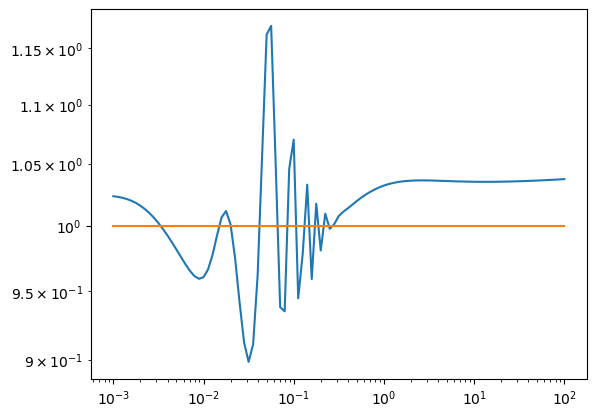

In [54]:
plt.loglog()
plt.plot(ks, Pks_lin/Psmt)
plt.plot(ks, Pdwg/Psmt)
sigma_v

## Parameters and ingredients

In [23]:
ingredients={'hmf': 'Sheth & Tormen (1999)', 
             'concentration': 'Duffy et al. (2008)',
             'halo definition': 'Mvir', 
             'profile': 'NFW'}

freeParsVanilla={   'eta':0, 
                    'B':4, 
                    'alpha1':1, 
                    'alpha2':1,
                    'kstar':0,
                    'f':0,
                    'kd':0,
                    'nd':1}

freeParsHMCode2020={'eta':0.139, 
                    'B':5.2, 
                    'alpha1':1, 
                    'alpha2':1,
                    'kstar':0.07,
                    'f':0,
                    'kd':0.073,
                    'nd':2.85}

In [24]:
BispecVanilla, Bi_1hVanilla, Bi_2hVanilla, Bi_3hVanilla=BiHMCode_bispectrum(ks, Pks_lin, Ms, camb_results, 
                                                                           Omega_m=Omega_m, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsVanilla,
                                                                           onlyEquilateral=False)

KeyboardInterrupt: 

In [ ]:
BispecHMCode2020, Bi_1hHMCode2020, Bi_2hHMCode2020, Bi_3hHMCode2020=BiHMCode_bispectrum(ks, Pks_lin, Ms, camb_results, 
                                                                           Omega_m=Omega_m, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           onlyEquilateral=False)

In [25]:
BispecVanilla_fast, Bi_1hVanilla_fast, Bi_2hVanilla_fast, Bi_3hVanilla_fast=BiHMCode_bispectrum(ks, Pks_lin, Ms, camb_results, 
                                                                           Omega_m=Omega_m, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsVanilla,
                                                                           onlyEquilateral=False,
                                                                           fastCalc=True)

KeyboardInterrupt: 

In [ ]:
BispecHMCode2020_fast, Bi_1hHMCode2020_fast, Bi_2hHMCode2020_fast, Bi_3hHMCode2020_fast=BiHMCode_bispectrum(ks, Pks_lin, Ms, camb_results, 
                                                                           Omega_m=Omega_m, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           onlyEquilateral=False,
                                                                           fastCalc=True)

In [59]:
BispecHMCode2020_fast_dwg, Bi_1hHMCode2020_fast_dwg, Bi_2hHMCode2020_fast_dwg, Bi_3hHMCode2020_fast_dwg=BiHMCode_bispectrum(ks, Pdwg, Ms, camb_results, 
                                                                           Omega_m=Omega_m, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           onlyEquilateral=False,
                                                                           fastCalc=True)

## Plots

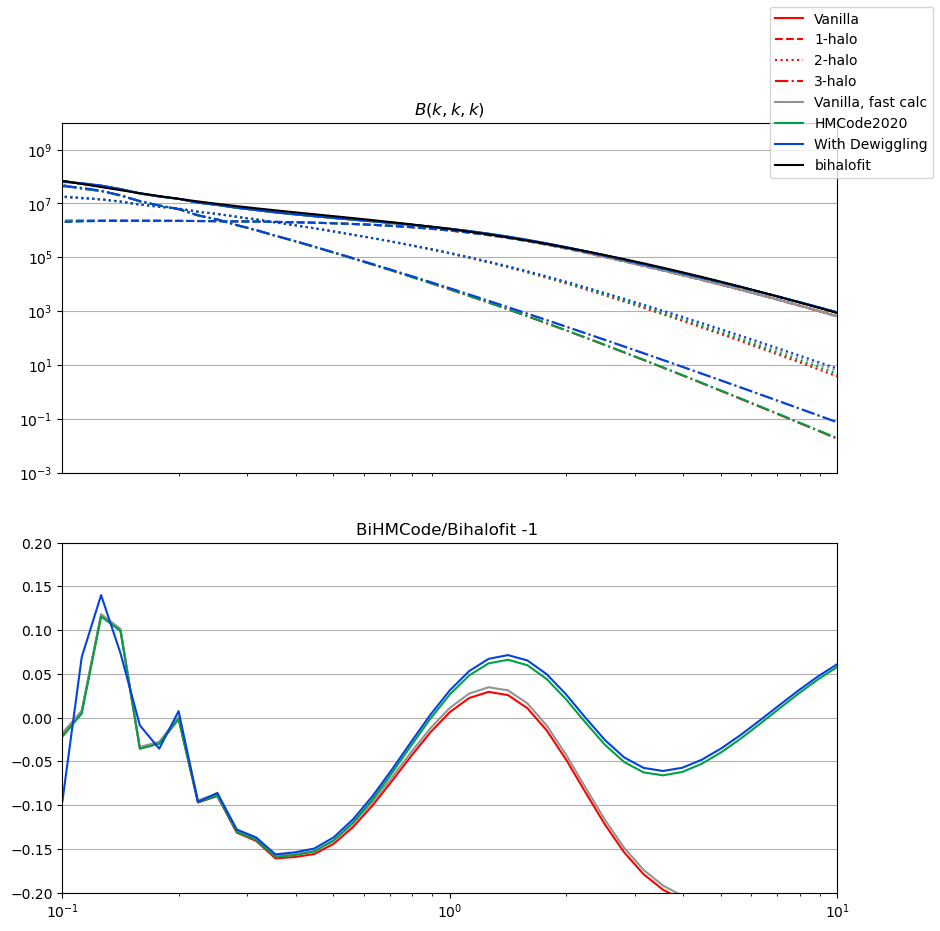

In [60]:
# Load bihalofit for comparison
dir="/home/laila/OneDrive/1_Work/5_Projects/05_BiHMCode/"
bihalofit=np.loadtxt(dir+"bihalofit/Bispectrum_from_Bihalofit.dat")

bihalofit_bispec=bihalofit[:,3]
bihalofit_k=bihalofit[:101,2]
bihalofit_bispec_res=bihalofit_bispec.reshape((101,101,101))

# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-0.2, 0.2)
axs[0].set_ylim(1e-3,1e10)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

axs[0].set_title(r"$B(k,k,k)$")
Halo1,=axs[0].plot(ks, np.array([BispecVanilla[i,i,i] for i in range(len(ks))]), label='Vanilla', ls='-', color='red')
Halo2,=axs[0].plot(ks, np.array([Bi_1hVanilla[i,i,i] for i in range(len(ks))]), label='1-halo', ls='--', color='red')
Halo3,=axs[0].plot(ks, np.array([Bi_2hVanilla[i,i,i] for i in range(len(ks))]), label='2-halo', ls=':', color='red')
BiHMCode,=axs[0].plot(ks, np.array([Bi_3hVanilla[i,i,i] for i in range(len(ks))]), label='3-halo', ls='-.', color='red')

Halo1FC,=axs[0].plot(ks, np.array([BispecVanilla_fast[i,i,i] for i in range(len(ks))]), label='Vanilla, fast calc',ls='-', color='xkcd:grey')
Halo2FC,=axs[0].plot(ks, np.array([Bi_1hVanilla_fast[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:grey')
Halo3FC,=axs[0].plot(ks, np.array([Bi_2hVanilla_fast[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:grey')
BiHMCodeFC,=axs[0].plot(ks, np.array([Bi_3hVanilla_fast[i,i,i] for i in range(len(ks))]),  ls='-.', color='xkcd:grey')

Halo1FCBloated,=axs[0].plot(ks, np.array([BispecHMCode2020[i,i,i] for i in range(len(ks))]), label='HMCode2020', ls='-', color='xkcd:emerald')
Halo2FCBloated,=axs[0].plot(ks, np.array([Bi_1hHMCode2020[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:emerald')
Halo3FCBloated,=axs[0].plot(ks, np.array([Bi_2hHMCode2020[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:emerald')
BiHMCodeFCBloated,=axs[0].plot(ks, np.array([Bi_3hHMCode2020[i,i,i] for i in range(len(ks))]), ls='-.', color='xkcd:emerald')


Halo1FCdwg,=axs[0].plot(ks, np.array([Bi_3hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls='-.', color='xkcd:blue')
Halo2FCdwg,=axs[0].plot(ks, np.array([Bi_1hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:blue')
Halo3FCdwg,=axs[0].plot(ks, np.array([Bi_2hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:blue')

BiHMCodeFCdwg,=axs[0].plot(ks, np.array([BispecHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), label='With Dewiggling', color='xkcd:blue')


Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,i,i] for i in range(len(ks))]), label='bihalofit', color='k')

alpha1=0.7
alpha2=1
#trans=np.array([np.power(np.power(np.power(Bi_1hHMCode2020[i,i,i], alpha1) + np.power(Bi_3hHMCode2020[i,i,i], alpha1), alpha2/alpha1) + np.power(Bi_2hHMCode2020[i,i,i], alpha2), 1/alpha2) for i in range(len(ks))])
#trans=np.array([1.2*Bi_1hHMCode2020[i,i,i]+Bi_3hHMCode2020[i,i,i]+Bi_2hHMCode2020[i,i,i] for i in range(len(ks))])



axs[1].set_title(r"BiHMCode/Bihalofit -1 ")
Ratio,=axs[1].plot(ks, np.array([BispecVanilla[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([BispecVanilla_fast[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:grey')
RatioFC,=axs[1].plot(ks, np.array([BispecHMCode2020[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:emerald')
RatioFC,=axs[1].plot(ks, np.array([BispecHMCode2020_fast_dwg[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:blue')

#RatioFC,=axs[1].plot(ks, trans/np.array([bihalofit_bispec_res[i,i,i] for i in range(len(ks))])-1, color='xkcd:orange')





fig.legend()


In [ ]:
%matplotlib widget

from ipywidgets import interact, widgets

# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-0.2, 0.2)
axs[0].set_ylim(5e3,1e15)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

axs[0].set_title(r"$B(k,k,$"+f"{ks[0]:.3f}"+"$h/Mpc)$")
Halo1,=axs[0].plot(ks, np.array([BispecVanilla[i,i,i] for i in range(len(ks))]), label='Vanilla', ls='-', color='red')
Halo2,=axs[0].plot(ks, np.array([Bi_1hVanilla[i,i,i] for i in range(len(ks))]), label='1-halo', ls='--', color='red')
Halo3,=axs[0].plot(ks, np.array([Bi_2hVanilla[i,i,i] for i in range(len(ks))]), label='2-halo', ls=':', color='red')
BiHMCode,=axs[0].plot(ks, np.array([Bi_3hVanilla[i,i,i] for i in range(len(ks))]), label='3-halo', ls='-.', color='red')

Halo1FC,=axs[0].plot(ks, np.array([BispecVanilla_fast[i,i,i] for i in range(len(ks))]), label='Vanilla, fast calc',ls='-', color='xkcd:grey')
Halo2FC,=axs[0].plot(ks, np.array([Bi_1hVanilla_fast[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:grey')
Halo3FC,=axs[0].plot(ks, np.array([Bi_2hVanilla_fast[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:grey')
BiHMCodeFC,=axs[0].plot(ks, np.array([Bi_3hVanilla_fast[i,i,i] for i in range(len(ks))]),  ls='-.', color='xkcd:grey')

Halo1FCBloated,=axs[0].plot(ks, np.array([BispecHMCode2020[i,i,i] for i in range(len(ks))]), label='HMCode2020', ls='-', color='xkcd:emerald')
Halo2FCBloated,=axs[0].plot(ks, np.array([Bi_1hHMCode2020[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:emerald')
Halo3FCBloated,=axs[0].plot(ks, np.array([Bi_2hHMCode2020[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:emerald')
BiHMCodeFCBloated,=axs[0].plot(ks, np.array([Bi_3hHMCode2020[i,i,i] for i in range(len(ks))]), ls='-.', color='xkcd:emerald')

Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,i,i] for i in range(len(ks))]), label='bihalofit')

alpha1=1.5
alpha2=0.5
trans=np.array([np.power(np.power(np.power(Bi_1hHMCode2020[i,i,i], alpha1) + np.power(Bi_2hHMCode2020[i,i,i], alpha1), alpha2/alpha1) + np.power(Bi_3hHMCode2020[i,i,i], alpha2), 1/alpha2) for i in range(len(ks))])

trans_arr=np.power(np.power(np.power(Bi_1hHMCode2020, alpha1) + np.power(Bi_2hHMCode2020, alpha1), alpha2/alpha1) + np.power(Bi_3hHMCode2020, alpha2), 1/alpha2)

axs[1].set_title(r"BiHMCode/Bihalofit -1 ")
Ratio,=axs[1].plot(ks, np.array([BispecVanilla[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([BispecVanilla_fast[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:grey')
RatioFCBloated,=axs[1].plot(ks, np.array([BispecHMCode2020[i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:emerald')
#RatioFCTrans,=axs[1].plot(ks, trans/np.array([bihalofit_bispec_res[i,i,i] for i in range(len(ks))])-1, color='xkcd:orange')




fig.legend()


def update(index_k3):
    axs[0].set_title(r"$B(k,k,$"+f"{ks[index_k3]:.3f}"+"$h/Mpc)$")

    Halo1.set_ydata(np.array([BispecVanilla[i,i,index_k3] for i in range(len(ks))]))
    Halo2.set_ydata(np.array([Bi_1hVanilla[i,i,index_k3] for i in range(len(ks))]))
    Halo3.set_ydata(np.array([Bi_2hVanilla[i,i,index_k3] for i in range(len(ks))]))
    BiHMCode.set_ydata(np.array([Bi_3hVanilla[i,i,index_k3] for i in range(len(ks))]))

    Halo1FC.set_ydata(np.array([BispecVanilla_fast[i,i,index_k3] for i in range(len(ks))]))
    Halo2FC.set_ydata(np.array([Bi_1hVanilla_fast[i,i,index_k3] for i in range(len(ks))]))
    Halo3FC.set_ydata(np.array([Bi_2hVanilla_fast[i,i,index_k3] for i in range(len(ks))]))
    BiHMCodeFC.set_ydata(np.array([Bi_3hVanilla_fast[i,i,index_k3] for i in range(len(ks))]))

    Halo1FCBloated.set_ydata(np.array([BispecHMCode2020[i,i,index_k3] for i in range(len(ks))]))
    Halo2FCBloated.set_ydata(np.array([BispecHMCode2020[i,i,index_k3] for i in range(len(ks))]))
    Halo3FCBloated.set_ydata(np.array([BispecHMCode2020[i,i,index_k3] for i in range(len(ks))]))
    BiHMCodeFCBloated.set_ydata(np.array([BispecHMCode2020[i,i,index_k3] for i in range(len(ks))]))

    Bihalofit.set_ydata(np.array([bihalofit_bispec_res[i,i,index_k3] for i in range(len(ks))]))
    Ratio.set_ydata(np.array([(BispecVanilla[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1   for i in range(len(ks))]))
    RatioFC.set_ydata(np.array([(BispecVanilla_fast[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1  for i in range(len(ks))]))
    RatioFCBloated.set_ydata(np.array([(BispecHMCode2020[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1  for i in range(len(ks))]))
    #RatioFCTrans.set_ydata(np.array([(trans_arr[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1  for i in range(len(ks))]))



    fig.canvas.draw_idle()

interact(update, index_k3=(40, 80))


## Initialization of halo model and profile

In [ ]:
# Initialise halo model
hmod = halo.model(z, Omega_m, name='Sheth & Tormen (1999)')
print(hmod)

In [ ]:
# Get sigma(R) from CAMB
Rs = hmod.Lagrangian_radius(Ms)
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[[z].index(z)]

In [ ]:
# Halo window functions
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
Uk = halo.window_function(ks, rvs, cs, profile='NFW')
nus=hmod._peak_height(Ms, sigmaRs)

eta=0.139#0.139
bloating=np.power(nus, eta)
rvs_bloated=rvs*bloating

Uk_bloated=halo.window_function(ks, rvs, 5.2/4*cs/bloating, profile='NFW')
print(Uk.shape)
print(Uk_bloated.shape)
#print(bloating)
# Create a profile, need mass_tracer=True here
matter_profile = halo.profile.Fourier(ks, Ms, Uk, amplitude=Ms, normalisation=hmod.rhom, mass_tracer=True) 
matter_profile_bloated=halo.profile.Fourier(ks, Ms, Uk_bloated, amplitude=Ms, normalisation=hmod.rhom, mass_tracer=True)
#print(matter_profile)


In [ ]:
plt.figure()
plt.plot(matter_profile.k, matter_profile.Uk[:,0], label="standard")
plt.plot(matter_profile_bloated.k, matter_profile_bloated.Uk[:,0], label="bloated")
plt.legend()
plt.show()

## Calculate power spectrum (optional)

In [ ]:
# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True)
Pk_2h_b, Pk_1h_b, Pk_hm_b = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile_bloated}, verbose=True)


## Calculate bispectrum

In [ ]:
result=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=False)
result_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=True)
result_fastCalc_bloated=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile_bloated}, verbose=True, fastCalc=True)



In [ ]:
result_unequi=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=False)
result_unequi_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=True)
result_unequi_fastCalc_bloated=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile_bloated}, verbose=True, onlyEquilateral=False, fastCalc=True)




## Plots

In [ ]:
# Load bihalofit for comparison
dir="/home/laila/OneDrive/1_Work/5_Projects/11_BiHMCode/"
bihalofit=np.loadtxt(dir+"bihalofit/Bispectrum_from_Bihalofit.dat")

bihalofit_bispec=bihalofit[:,3]
bihalofit_k=bihalofit[:101,2]

In [ ]:
bihalofit_bispec_res=bihalofit_bispec.reshape((101,101,101))
bihalofit_bispec_diag=np.array([bihalofit_bispec_res[i,i,i] for i in range(len(bihalofit_k))])

In [ ]:
# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-0.5, 0.5)
axs[0].set_ylim(1e-3,1e9)
axs[0].set_xlim(0.01, 10)
axs[1].set_xlim(0.01, 10)

axs[0].set_title(r"$B(k,k,k)$")
Halo1,=axs[0].plot(ks, np.array([result_unequi[2]['m-m-m'][i,i,i] for i in range(len(ks))]), label='1-halo', ls='--')
Halo2,=axs[0].plot(ks, np.array([result_unequi[1]['m-m-m'][i,i,i] for i in range(len(ks))]), label='2-halo', ls=':')
Halo3,=axs[0].plot(ks, np.array([result_unequi[0]['m-m-m'][i,i,i] for i in range(len(ks))]), label='3-halo', ls='-.')
BiHMCode,=axs[0].plot(ks, np.array([result_unequi[3]['m-m-m'][i,i,i] for i in range(len(ks))]), label='all', color='red')

Halo1FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[2]['m-m-m'][i,i,i] for i in range(len(ks))]), label='1-halo, fast calc', ls='--')
Halo2FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[1]['m-m-m'][i,i,i] for i in range(len(ks))]), label='2-halo, fast calc', ls=':')
Halo3FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[0]['m-m-m'][i,i,i] for i in range(len(ks))]), label='3-halo, fast calc', ls='-.')
BiHMCodeFC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,i,i] for i in range(len(ks))]), label='all, fast calc', color='xkcd:grey')

Halo1FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[2]['m-m-m'][i,i,i] for i in range(len(ks))]), label='1-halo, fast calc, bloated', ls='--')
Halo2FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[1]['m-m-m'][i,i,i] for i in range(len(ks))]), label='2-halo, fast calc, bloated', ls=':')
Halo3FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[0]['m-m-m'][i,i,i] for i in range(len(ks))]), label='3-halo, fast calc, bloated', ls='-.')
BiHMCodeFCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[3]['m-m-m'][i,i,i] for i in range(len(ks))]), label='all, fast calc, bloated', color='xkcd:emerald')

Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,i,i] for i in range(len(ks))]), label='bihalofit')


axs[1].set_title(r"BiHMCode/Bihalofit -1 ")
Ratio,=axs[1].plot(ks, np.array([result_unequi[3]['m-m-m'][i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:grey')
RatioFC,=axs[1].plot(ks, np.array([result_unequi_fastCalc_bloated[3]['m-m-m'][i,i,i]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:emerald')




fig.legend()


In [ ]:
%matplotlib widget

from ipywidgets import interact, widgets

# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-0.5, 0.5)
axs[0].set_ylim(5e3,1e15)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

axs[0].set_title(r"$B(k,k,$"+f"{ks[0]:.3f}"+"$h/Mpc)$")
Halo1,=axs[0].plot(ks, np.array([result_unequi[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo', ls='--')
Halo2,=axs[0].plot(ks, np.array([result_unequi[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo', ls=':')
Halo3,=axs[0].plot(ks, np.array([result_unequi[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo', ls='-.')
BiHMCode,=axs[0].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all', color='red')

Halo1FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo, fast calc', ls='--')
Halo2FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo, fast calc', ls=':')
Halo3FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo, fast calc', ls='-.')
BiHMCodeFC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all, fast calc', color='xkcd:grey')

Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,0,0] for i in range(len(ks))]), label='bihalofit')


Halo1FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo, fast calc, bloated', ls='--')
Halo2FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo, fast calc, bloated', ls=':')
Halo3FCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo, fast calc, bloated', ls='-.')
BiHMCodeFCBloated,=axs[0].plot(ks, np.array([result_unequi_fastCalc_bloated[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all, fast calc, bloated', color='xkcd:emerald')


axs[1].set_title(r"BiHMCode/Bihalofit -1 ")
Ratio,=axs[1].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0] -1 for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0] -1 for i in range(len(ks))]), color='xkcd:grey')
RatioFCBloated,=axs[1].plot(ks, np.array([result_unequi_fastCalc_bloated[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,i,i] -1 for i in range(len(ks))]), color='xkcd:emerald')




fig.legend()


def update(index_k3):
    axs[0].set_title(r"$B(k,k,$"+f"{ks[index_k3]:.3f}"+"$h/Mpc)$")

    Halo1.set_ydata(np.array([result_unequi[2]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo2.set_ydata(np.array([result_unequi[1]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo3.set_ydata(np.array([result_unequi[0]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    BiHMCode.set_ydata(np.array([result_unequi[3]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))

    Halo1FC.set_ydata(np.array([result_unequi_fastCalc[2]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo2FC.set_ydata(np.array([result_unequi_fastCalc[1]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo3FC.set_ydata(np.array([result_unequi_fastCalc[0]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    BiHMCodeFC.set_ydata(np.array([result_unequi_fastCalc[3]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))

    Halo1FCBloated.set_ydata(np.array([result_unequi_fastCalc_bloated[2]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo2FCBloated.set_ydata(np.array([result_unequi_fastCalc_bloated[1]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo3FCBloated.set_ydata(np.array([result_unequi_fastCalc_bloated[0]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    BiHMCodeFCBloated.set_ydata(np.array([result_unequi_fastCalc_bloated[3]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))

    Bihalofit.set_ydata(np.array([bihalofit_bispec_res[i,i,index_k3] for i in range(len(ks))]))
    Ratio.set_ydata(np.array([(result_unequi[3]['m-m-m'][i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1   for i in range(len(ks))]))
    RatioFC.set_ydata(np.array([(result_unequi_fastCalc[3]['m-m-m'][i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1  for i in range(len(ks))]))
    RatioFCBloated.set_ydata(np.array([(result_unequi_fastCalc_bloated[3]['m-m-m'][i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])-1  for i in range(len(ks))]))


    fig.canvas.draw_idle()

interact(update, index_k3=(40, 80))
